In [1]:
import sys, os, distutils.core
sys.path.insert(0, os.path.abspath('../../../detectron2'))
sys.path.insert(0, os.path.abspath('../../../'))
sys.path.insert(0, os.path.abspath('.'))
os.environ['DETECTRON2_DATASETS'] = '/home/liwa/data/datasets/'

from detectron2.data import DatasetCatalog, MetadataCatalog
# from oneformer.data.datasets.register_yeast_panoptic_annos_semseg import register_all_yeast_panoptic_annos_sem_seg

/home/liwa/miniconda3/envs/oneformer/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from detectron2.config import get_cfg
from detectron2.projects.panoptic_deeplab import (
    PanopticDeeplabDatasetMapper,
    add_panoptic_deeplab_config,
)
from detectron2.engine import default_setup
from detectron2.engine import DefaultPredictor
from prediction import Predictor
from google.colab.patches import cv2_imshow
import os, json, cv2, random
from detectron2.utils.visualizer import Visualizer
import torch

In [3]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:8700m"
cfg = get_cfg()
add_panoptic_deeplab_config(cfg)
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file("/home/liwa/data/oneformer_output/output/config.yaml")

cfg.MODEL.DEVICE = "cuda"
# into cpu model
cfg.MODEL.SEM_SEG_HEAD.NORM = "BN"
cfg.MODEL.INS_EMBED_HEAD.NORM = "BN"
cfg.MODEL.RESNETS.NORM = "BN"

# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model

# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = os.path.abspath("/home/liwa/data/oneformer_output/output/model_0001999.pth")
# cfg.MODEL.WEIGHTS = "detectron2://DeepLab/R-52.pkl"
# cfg.INPUT.MIN_SIZE_TEST = 512
# cfg.INPUT.MAX_SIZE_TRAIN = 2048

In [4]:
from skimage.io import imread
import numpy as np

In [5]:
predictor = Predictor(cfg)

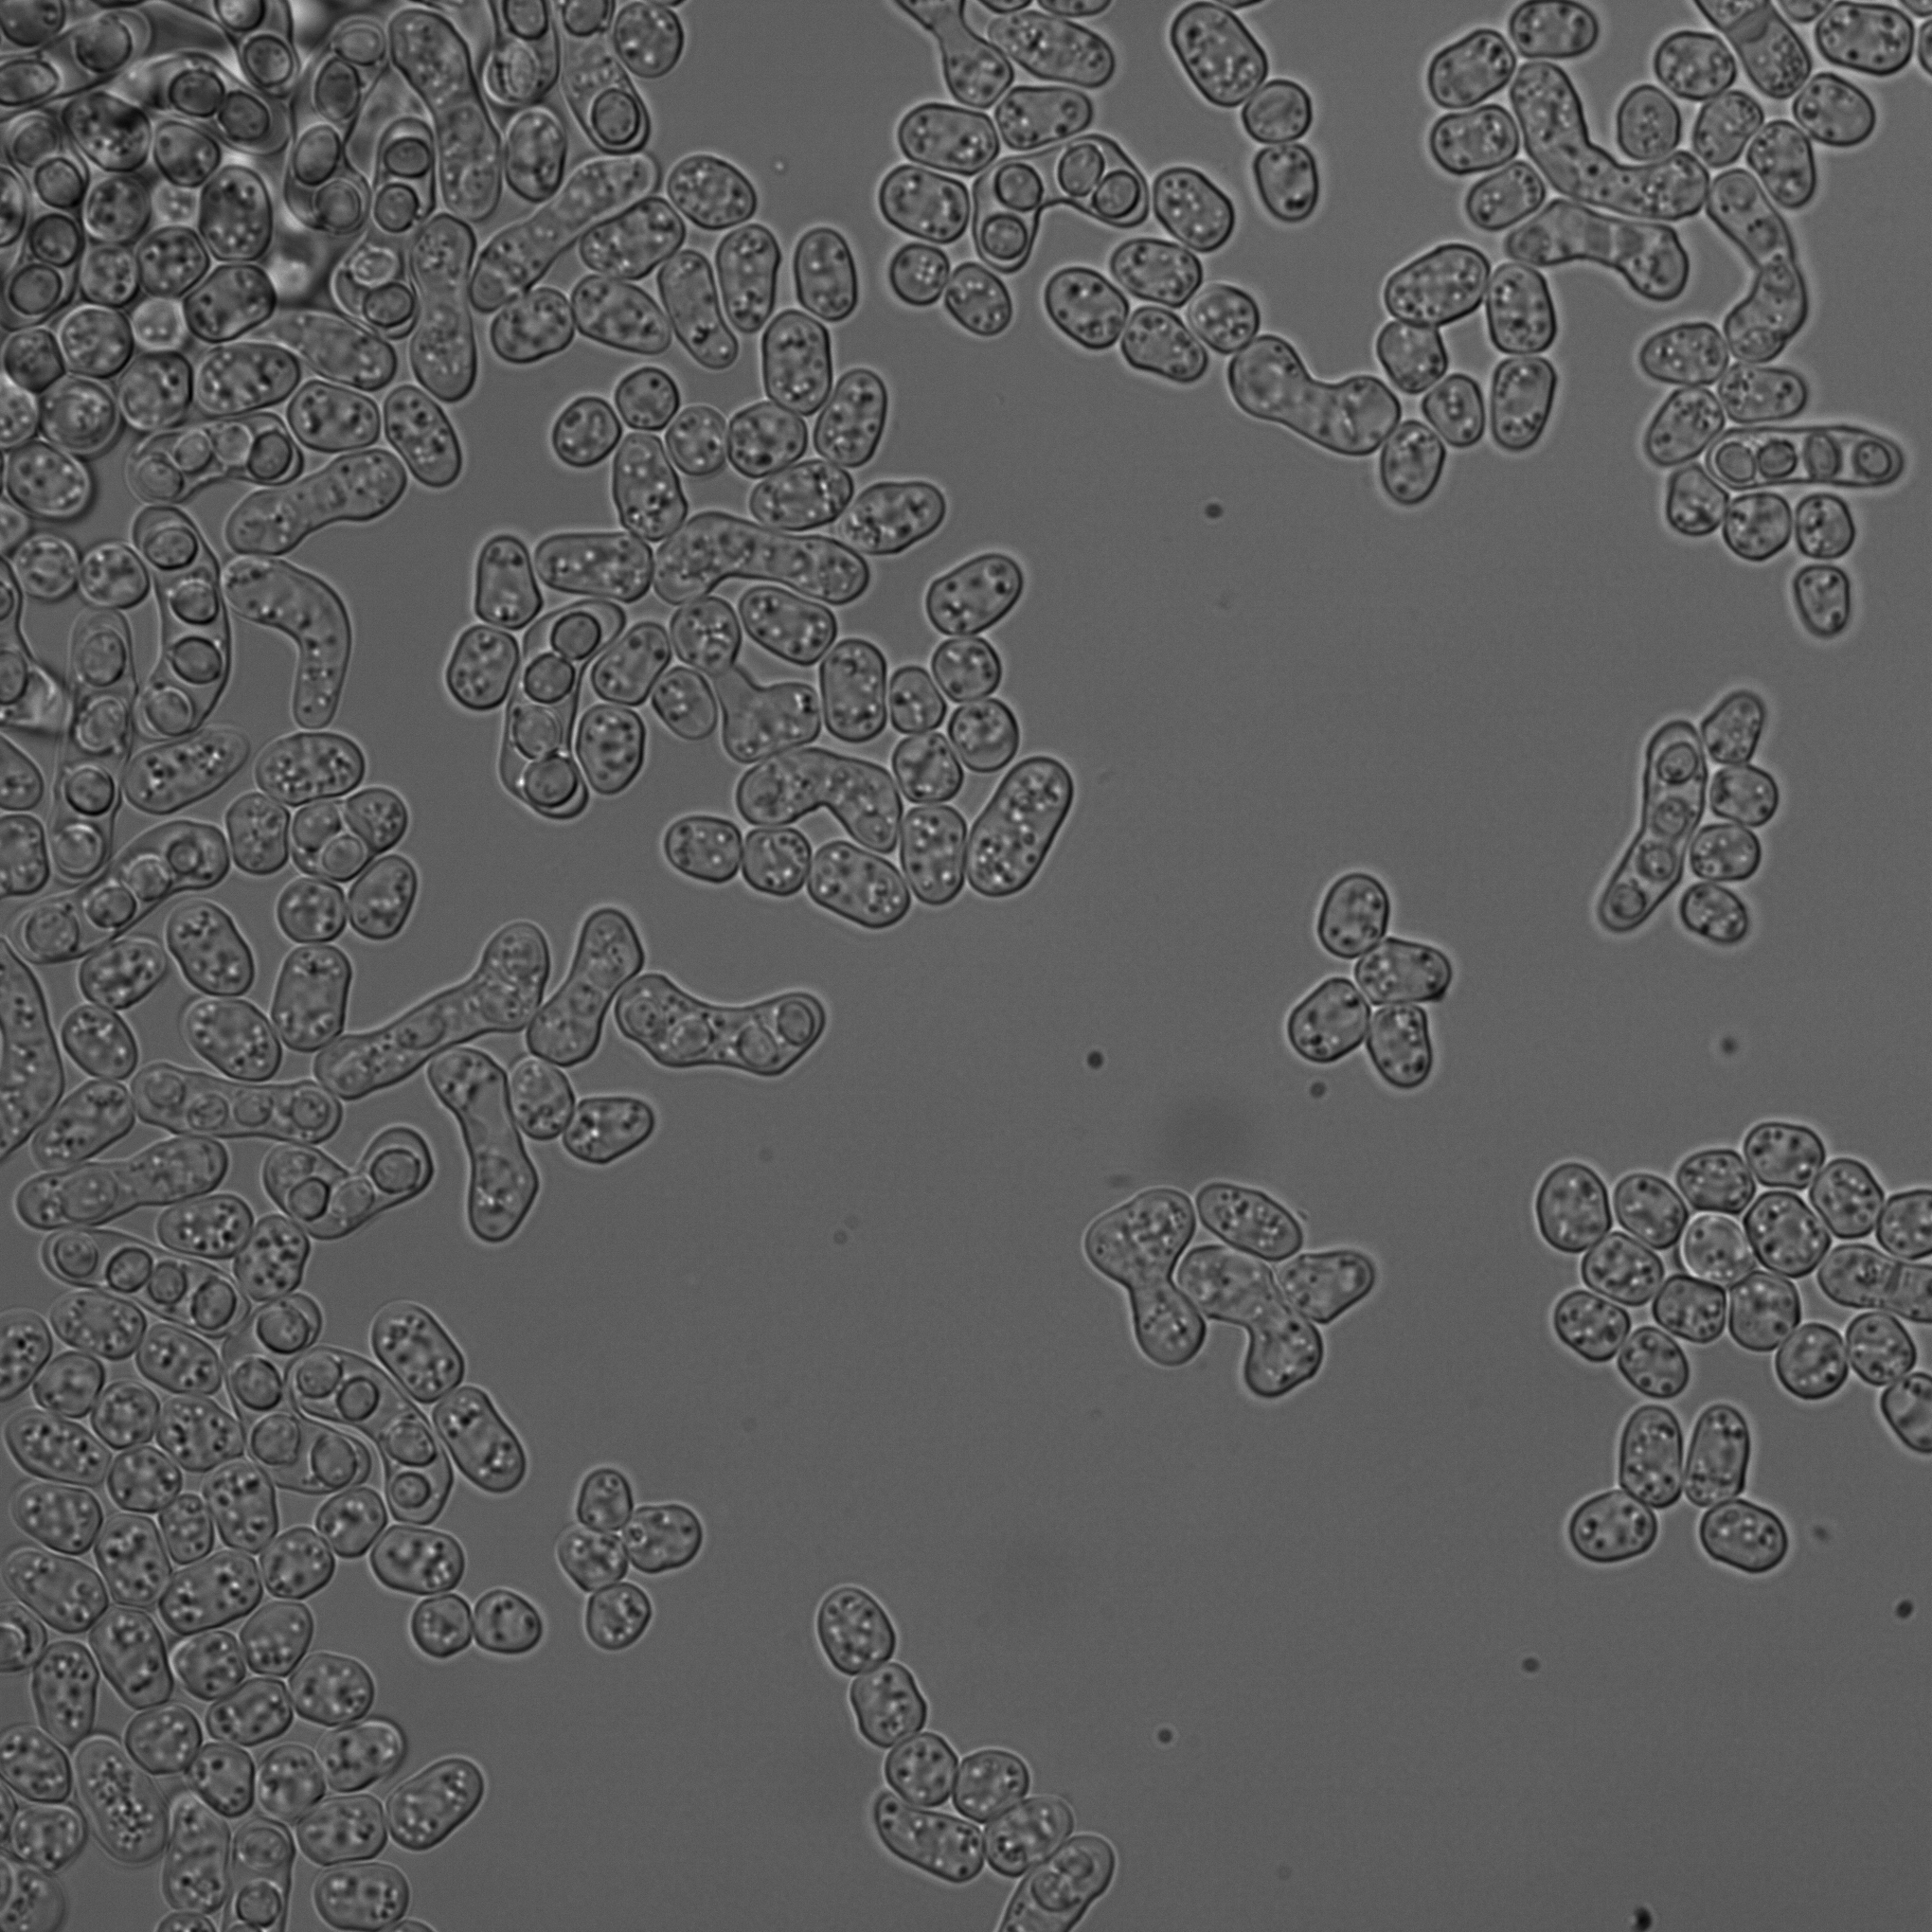

In [376]:
# im = cv2.imread("./00413.png")

im = imread("./testimages/00245_leftImg8bit.png")
# image = image - image.min()
# image = image / image.max()
# image = (image * 255).astype(np.uint8)
# im = np.stack((image,)*3, axis=-1)

cv2_imshow(im)

In [391]:
# bigimage = np.zeros((512*4,512*4,3), dtype = np.uint8)
# for i in range(0, 4):
#     for j in range(0,4):
#         bigimage[i*512:(i+1)*512, j*512:(j+1)*512, :] = im
# cv2_imshow(bigimage)
# bigimage.shape
bigimage = im[0:520,1560:2040,:]

In [392]:
prediction_output = predictor(bigimage)
print(prediction_output.keys())


instances = prediction_output["instances"]
panoptic_seg, segments_info = prediction_output["panoptic_seg"]


scores = [1]+list(instances.scores.to("cpu"))
bboxes = instances.pred_boxes.to("cpu")
bboxes = [np.array([0,0,0,0])] + list(instances.pred_boxes.to("cpu"))

dict_keys(['sem_seg', 'center', 'offset', 'panoptic_seg', 'instances'])


In [393]:
segments_info = []
i=0
for panoptic_label in np.unique(panoptic_seg.to("cpu").numpy()):
    if panoptic_label == -1:
        # VOID region.
        continue
    pred_class = panoptic_label // 1000
    # isthing = pred_class in metadata.thing_dataset_id_to_contiguous_id.values()
    if i == 0:
        isthing = False
    else:
        isthing = True
    box = bboxes[i]
    segments_info.append(
        {
            "id": int(panoptic_label),
            "category_id": int(pred_class),
            "isthing": isthing,
            "score": float(scores[i]),
        }
    )
    i += 1

{0: {'id': 0, 'category_id': 0, 'isthing': False, 'score': 1.0}, 1001: {'id': 1001, 'category_id': 1, 'isthing': True, 'score': 0.9825855493545532}, 1002: {'id': 1002, 'category_id': 1, 'isthing': True, 'score': 0.9521209001541138}, 1003: {'id': 1003, 'category_id': 1, 'isthing': True, 'score': 0.9834728240966797}, 1004: {'id': 1004, 'category_id': 1, 'isthing': True, 'score': 0.9894691705703735}, 1005: {'id': 1005, 'category_id': 1, 'isthing': True, 'score': 0.9186074137687683}, 1006: {'id': 1006, 'category_id': 1, 'isthing': True, 'score': 0.9725098013877869}, 1007: {'id': 1007, 'category_id': 1, 'isthing': True, 'score': 0.9599803686141968}, 1008: {'id': 1008, 'category_id': 1, 'isthing': True, 'score': 0.9775630235671997}, 1009: {'id': 1009, 'category_id': 1, 'isthing': True, 'score': 0.9851911664009094}, 1010: {'id': 1010, 'category_id': 1, 'isthing': True, 'score': 0.9991798400878906}, 1011: {'id': 1011, 'category_id': 1, 'isthing': True, 'score': 0.9844892621040344}, 1012: {'id'

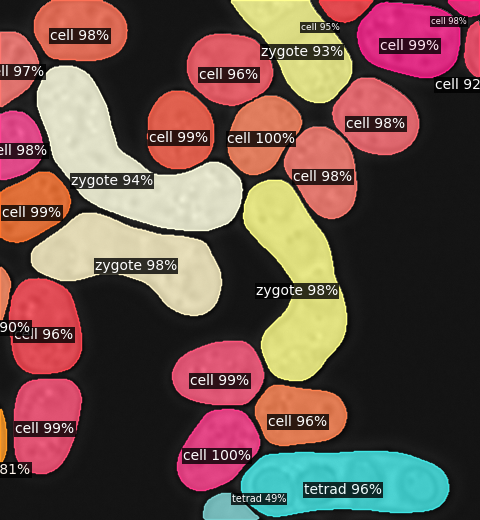

In [394]:
# panoptic_seg, segments_info = prediction_output["panoptic_seg"]
v = Visualizer(bigimage[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
out = v.draw_panoptic_seg(panoptic_seg.to("cpu"), segments_info, area_threshold=0.0, alpha=0.8)
cv2_imshow(out.get_image()[:, :, ::-1])

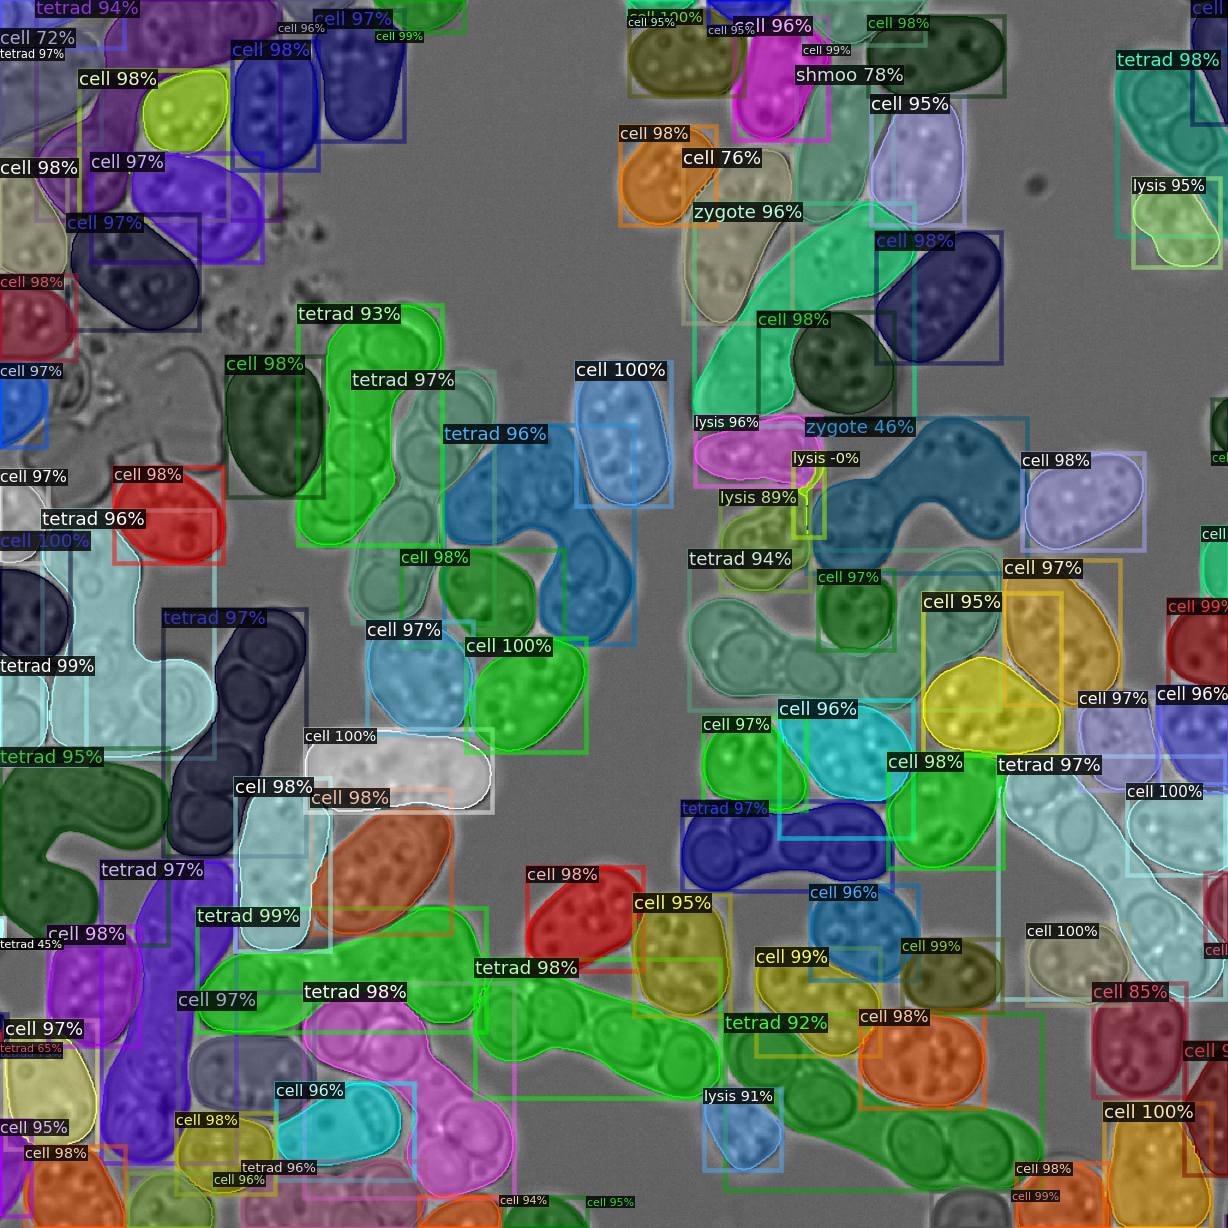

In [57]:
instances = prediction_output["instances"]
v = Visualizer(bigimage[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(instances.to("cpu"), segments_info)
cv2_imshow(out.get_image()[:, :, ::-1])

In [19]:
from tqdm import trange
from pathlib import Path

In [31]:
imagelist = list(Path("./testimages/").glob("*.png"))
imagelist.sort()
imagelist = [i for i in imagelist if i.name[-6]!='-']
print(imagelist)

[PosixPath('testimages/00088_leftImg8bit.png'), PosixPath('testimages/00111_leftImg8bit.png'), PosixPath('testimages/00245_leftImg8bit.png'), PosixPath('testimages/00331.png'), PosixPath('testimages/00349.png'), PosixPath('testimages/00350.png'), PosixPath('testimages/00351.png'), PosixPath('testimages/00391.png'), PosixPath('testimages/00396.png'), PosixPath('testimages/00398.png'), PosixPath('testimages/00410.png')]


In [32]:
sem_features = []
types = []
name = []

for file in imagelist:
    im = imread(file)
    for crop_i in trange(0, (im.shape[0] // 520) + 1):
        for crop_j in range(0, (im.shape[0] // 520) + 1):
            cropped_im = im[crop_i*520:(crop_i+1)*520, crop_j*520:(crop_j+1)*520]
            prediction_output = predictor(cropped_im)
            sem_scores = prediction_output['sem_seg'].to("cpu").numpy()
            panoptic_seg, segments_info = prediction_output["panoptic_seg"]
            data = panoptic_seg.to("cpu").numpy()
            if "instances" not in prediction_output:
                continue
            bboxes = list(prediction_output['instances'].pred_boxes.to("cpu"))
            pred_scores = list(prediction_output['instances'].scores.to("cpu"))
            labels = np.unique(data)[1:]
            for i in range(0, len(labels)):
                if pred_scores[i] < 0.65:
                    continue
                if bboxes[i].min() == 0:
                    continue
                if bboxes[i][2] == cropped_im.shape[0]:
                    continue
                if bboxes[i][3] == cropped_im.shape[1]:
                    continue
                # score_dim = sem_scores[:,data==labels[i]].(axis=1)#[:6]
                score_dim = np.percentile(sem_scores[:,data==labels[i]], 80 ,axis=1)
                sem_features.append(score_dim)
                types.append([labels[i] // 1000])
                name.append(file.name)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.26it/s]


In [37]:
slected_imagelist = list(Path("./testimages/").glob("*-*.png"))
slected_imagelist.sort()
print(slected_imagelist)


selected_sem_features = []
selected_types = []
selected_name = []

for file in slected_imagelist:
    im = imread(file)
    for crop_i in trange(0, (im.shape[0] // 520) + 1):
        for crop_j in range(0, (im.shape[0] // 520) + 1):
            cropped_im = im[crop_i*520:(crop_i+1)*520, crop_j*520:(crop_j+1)*520]
            prediction_output = predictor(cropped_im)
            sem_scores = prediction_output['sem_seg'].to("cpu").numpy()
            panoptic_seg, segments_info = prediction_output["panoptic_seg"]
            data = panoptic_seg.to("cpu").numpy()
            if "instances" not in prediction_output:
                continue
            bboxes = list(prediction_output['instances'].pred_boxes.to("cpu"))
            pred_scores = list(prediction_output['instances'].scores.to("cpu"))
            labels = np.unique(data)[1:]
            for i in range(0, len(labels)):
                if bboxes[i].min() == 0:
                    continue
                if bboxes[i][2] == cropped_im.shape[0]:
                    continue
                if bboxes[i][3] == cropped_im.shape[1]:
                    continue
                # score_dim = sem_scores[:,data==labels[i]].(axis=1)#[:6]
                score_dim = np.percentile(sem_scores[:,data==labels[i]], 80 ,axis=1)
                selected_sem_features.append(score_dim)
                selected_types.append([labels[i] // 1000])
                selected_name.append(file.name)

[PosixPath('testimages/00351-1.png'), PosixPath('testimages/00351-2.png'), PosixPath('testimages/00389-1.png'), PosixPath('testimages/00392-1.png'), PosixPath('testimages/00411-1.png')]


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.74it/s]


In [38]:
X = np.array(sem_features+selected_sem_features)[:,:6]
Y = np.array(types+selected_types)
all_name = name+selected_name

In [46]:
import pandas as pd

# Convert to a DataFrame for easier handling (optional)
all_data = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(X.shape[1])])
all_data["label"] = Y
all_data["name"] = all_name

data = all_data.loc[all_data.label < 6]


# Group by class and sample
n_samples_per_class = data["label"].value_counts().min()  # Minimum samples per class
desired_samples = 90
sampled_data = data.groupby("label", group_keys=False).apply(
    lambda group: group.sample(n=min(len(group), desired_samples), random_state=42)
)

for i in range(0, len(slected_imagelist)):
    imagename = slected_imagelist[i].name
    sampled_data = pd.concat([sampled_data, all_data[(all_data.name == imagename)]])
    # sampled_data = pd.concat([sampled_data, all_data[(all_data.name == imagelist[5].name)]])
    # sampled_data = pd.concat([sampled_data, all_data[(all_data.name == imagelist[7].name)]])

# Split back into X and Y
X_sampled = sampled_data.drop(columns=["label","name"]).values
Y_sampled = sampled_data["label"].values

# Check results
print(f"Original class distribution:\n{data['label'].value_counts()}")
print(f"Sampled class distribution:\n{sampled_data['label'].value_counts()}")


Original class distribution:
label
1    1649
4     414
3      95
2      33
5       7
Name: count, dtype: int64
Sampled class distribution:
label
1    107
4     99
3     90
2     34
5      8
Name: count, dtype: int64


In [47]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

scaler = StandardScaler()
# data_normalized = scaler.fit_transform(X_sampled)
data_normalized = X_sampled

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=50).fit_transform(data_normalized)
X_embedded.shape

(338, 2)

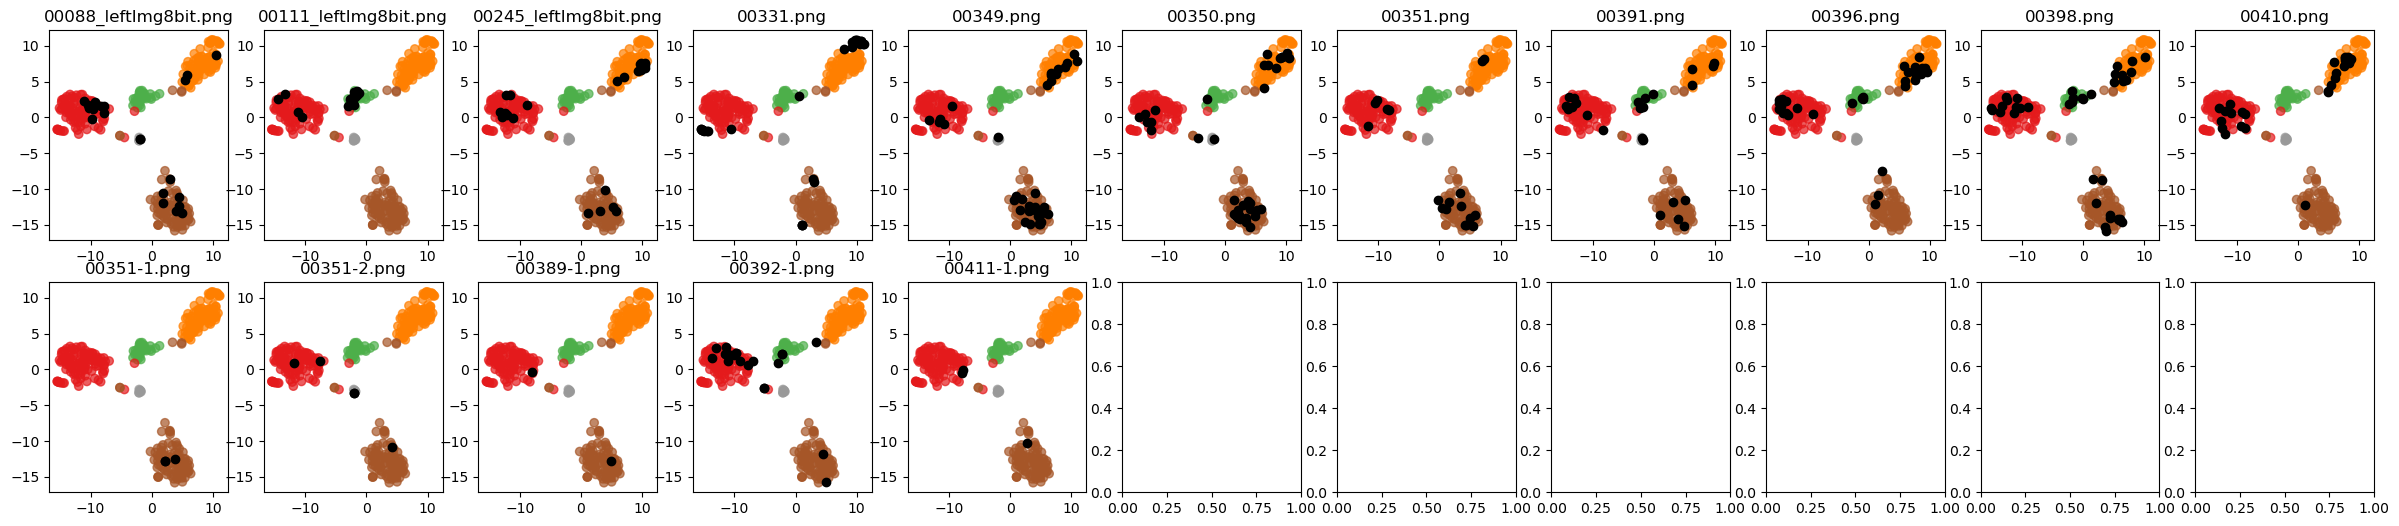

In [48]:
fig, axs = plt.subplots(2, len(imagelist), figsize=(30, 6))
for i in range(0, len(imagelist)):
    index = sampled_data.name == imagelist[i].name
    scatter = axs[0, i].scatter(X_embedded[~index, 0], X_embedded[~index, 1], c=Y_sampled[~index], cmap='Set1', alpha=0.7)
    scatter = axs[0, i].scatter(X_embedded[index, 0], X_embedded[index, 1], c='black',alpha=1)
    axs[0, i].set_title(imagelist[i].name)

for i in range(0, len(slected_imagelist)):
    index = sampled_data.name == slected_imagelist[i].name
    scatter = axs[1, i].scatter(X_embedded[~index, 0], X_embedded[~index, 1], c=Y_sampled[~index], cmap='Set1', alpha=0.7)
    scatter = axs[1, i].scatter(X_embedded[index, 0], X_embedded[index, 1], c='black',alpha=1)
    axs[1, i].set_title(slected_imagelist[i].name)
    # plt.colorbar(scatter, label="Class Label")
    # plt.title("t-SNE Visualization")
    # plt.xlabel("t-SNE Dimension 1")
    # plt.ylabel("t-SNE Dimension 2")
# plt.savefig("tnse-class.svg")
# plt.show()

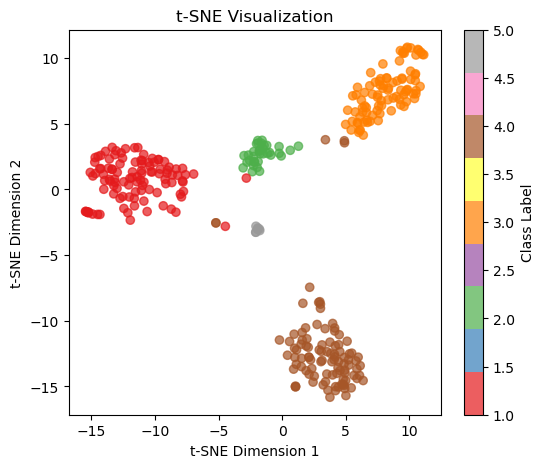

In [51]:
plt.figure(figsize=(6, 5))
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=Y_sampled, cmap='Set1', alpha=0.7)
plt.colorbar(scatter, label="Class Label")
plt.title("t-SNE Visualization")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.savefig("tnse-class.svg")
plt.show()

PosixPath('testimages/00392-1.png')